In [1]:
%%capture
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax_cosmo.emulator import EMUCMBdata, prediction_cmb_cls
from cmbrun.cmbcls import calculate_cmb_cls_class, compute_cmb_gradients, get_config
from cmbrun.emulation import JAXPreprocessingPipeline

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 20

In [2]:
cfg = get_config("planck")
emudata = EMUCMBdata(cfg)
cosmology = np.array([0.8120, 0.265, 0.04938, 0.6732, 0.96605])

## GP and CLASS Calculation

In [3]:
# using the emulator to predict the power spectra
mean_tt_jax = prediction_cmb_cls(cosmology, emudata, "tt")
mean_te_jax = prediction_cmb_cls(cosmology, emudata, "te")
mean_ee_jax = prediction_cmb_cls(cosmology, emudata, "ee")

In [4]:
# using CLASS to predict the power spectra
cosmo_dict = {name: cosmology[i] for i, name in enumerate(cfg.cosmo.names)}
_, cls_tt, cls_ee, cls_te = calculate_cmb_cls_class(cosmo_dict, cfg)

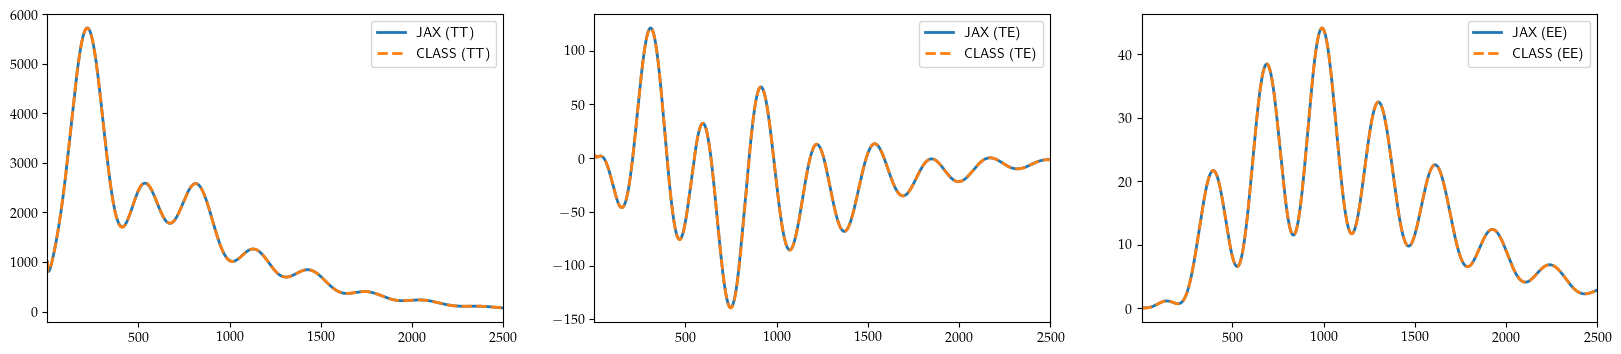

In [5]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(emudata.ells, mean_tt_jax, linestyle="-", lw=2, label="JAX (TT)")
plt.plot(emudata.ells, cls_tt, linestyle="--", lw=2, label="CLASS (TT)")
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc="best")

plt.subplot(132)
plt.plot(emudata.ells, mean_te_jax, linestyle="-", lw=2, label="JAX (TE)")
plt.plot(emudata.ells, cls_te, linestyle="--", lw=2, label="CLASS (TE)")
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc="best")

plt.subplot(133)
plt.plot(emudata.ells, mean_ee_jax, linestyle="-", lw=2, label="JAX (EE)")
plt.plot(emudata.ells, cls_ee, linestyle="--", lw=2, label="CLASS (EE)")
plt.xlim(min(emudata.ells), max(emudata.ells))
plt.legend(loc="best")

plt.show()

## First Derivative

In [6]:
def plot_gradient(
    gradient: jnp.array,
    gradient_class: dict,
    labels: list,
    emudata: EMUCMBdata,
    type: str,
):
    """Plots the gradient of power spectra components.

    Args:
        gradient (jnp.array): A 2D array where each column represents a gradient of a different parameter.
        gradient_class (dict): A dictionary containing gradients computed by CLASS.
        labels (list): A list of labels for the different components of the gradient.
        emudata (EMUCMBdata): An object containing CMB multipoles (ells) used for the x-axis.
        type (str): The type of power spectrum component (e.g., 'TT', 'EE', 'TE').

    Raises:
        ValueError: If the length of `labels` is less than 5 or if `gradient` has fewer than 5 columns.

    """
    plt.figure(figsize=(18, 6))
    for i in range(5):
        plt.subplot(2, 3, i + 1)
        plt.plot(emudata.ells, gradient[:, i], lw=2, label="JAX")
        plt.plot(
            emudata.ells,
            gradient_class[type][:, i],
            linestyle="--",
            lw=2,
            label="CLASS",
        )
        plt.xlabel(r"$\ell$")
        plt.ylabel(labels[i])
        plt.xlim(min(emudata.ells), max(emudata.ells))
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        plt.legend(loc="best")
    plt.show()

In [7]:
# first derivative using JAX
gradient_tt = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type="tt")
gradient_te = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type="te")
gradient_ee = jax.jacrev(prediction_cmb_cls)(cosmology, emudata, cls_type="ee")

In [8]:
# first derivative using CLASS
gradients_class = compute_cmb_gradients(cosmology, cfg)

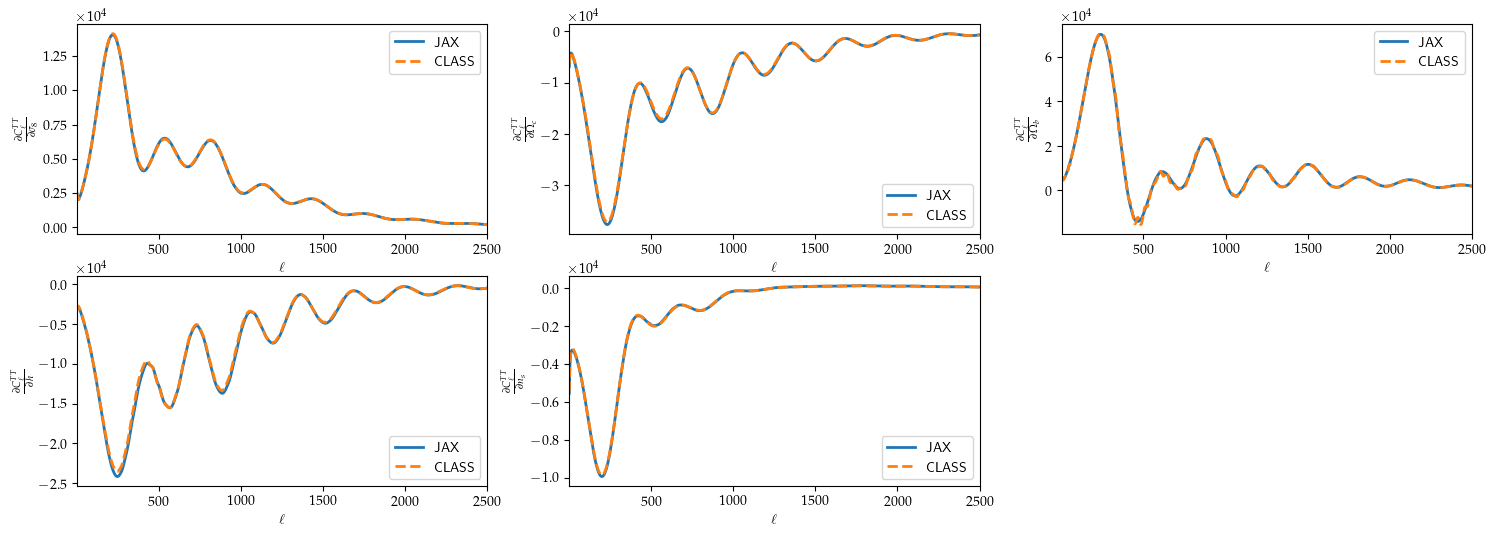

In [9]:
labels_grad_tt = [
    r"$\frac{\partial C_{\ell}^{TT}}{\partial \sigma_{8}}$",
    r"$\frac{\partial C_{\ell}^{TT}}{\partial \Omega_{c}}$",
    r"$\frac{\partial C_{\ell}^{TT}}{\partial \Omega_{b}}$",
    r"$\frac{\partial C_{\ell}^{TT}}{\partial h}$",
    r"$\frac{\partial C_{\ell}^{TT}}{\partial n_{s}}$",
]

plot_gradient(gradient_tt, gradients_class, labels_grad_tt, emudata, "tt")